# Mise en avant des potentiels évoqués visuels stationnaires avec utilisation des densités spectrales de puissance

Notebook utilisé lors de la présentation au client le jeudi 16 décembre 2021

Source : https://mne.tools/stable/auto_tutorials/time-freq/50_ssvep.html#sphx-glr-auto-tutorials-time-freq-50-ssvep-py

In [ ]:
!pip install mne 
import matplotlib.pyplot as plt
import mne
import numpy as np

     |████████████████████████████████| 7.4 MB 5.1 MB/s 


In [ ]:
%matplotlib inline
from mne.io import read_raw_edf

# Préparation de nos données

In [ ]:
#Renseigner ici le nom du fichier .txt importé
filepath='new.txt'

Convertion du fichier en un format lisible par la bibliothèque mne

In [ ]:
raw_data = np.genfromtxt(filepath, delimiter=',',skip_header=5)
#on a un tableau où chaque ligne représente toutes les mesures prises par toutes les électrodes à l'instant t
data=np. transpose (raw_data) 
#colonne = 1 électrode

#to raw
data=np.delete(data, np.s_[6:26], axis=0)
data=np.delete(data,np.s_[0:1],axis=0)
print(data.shape)

#Création du type info
n_channels=8
ch_names=['c1','c2','c3','c4','c5']
#c1 et c2 sont placées au-dessus des yeux et serviront de références EOG
ch_types=['eeg']*5
f_e=250 #Hz
info_data=mne.create_info(ch_names,ch_types=ch_types,sfreq=f_e)
print(info_data)

time=np.linspace(0,(1/f_e)*data.shape[1],data.shape[1])

#création du type Array
raw=mne.io.RawArray(data,info_data)

(5, 71649)
<Info | 7 non-empty values
 bads: []
 ch_names: c1, c2, c3, c4, c5
 chs: 5 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: unspecified
 nchan: 5
 projs: []
 sfreq: 250.0 Hz
>
Creating RawArray with float64 data, n_channels=5, n_times=71649
    Range : 0 ... 71648 =      0.000 ...   286.592 secs
Ready.


In [ ]:
raw.load_data()
events = mne.find_events(raw, stim_channel='auto')
print(events)

ValueError: ignored

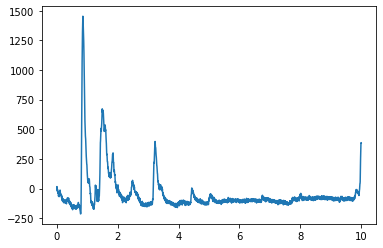

In [ ]:
eeg_array = raw.get_data()
duration=10
f_e=int(raw.info['sfreq'])
time=raw.times[:duration*f_e]
amplitude=eeg_array[4][:duration*f_e]
plt.plot(time,amplitude)
plt.show()

# Analyse & pré-traitement

Suppression de la **composante continue** et **filtre passe-bande**

In [ ]:
#set common average reference
raw.set_eeg_reference('average',projection=False,verbose=False)
#apply bandpass filter
raw.filter(l_freq=1,h_freq=50,fir_design='firwin',verbose=False)

<RawArray | 5 x 71649 (286.6 s), ~2.7 MB, data loaded>

On essaye ici de **supprimer les artefacts occulaires**

In [ ]:
#EOG artefacts (channels 1 and 2 (above eyes))
from mne.preprocessing import create_eog_epochs
eog_evoked = create_eog_epochs(raw,['c1','c2']).average()
eog_evoked.apply_baseline(baseline=(None,-0.2))
#eog_evoked.plot_joint()

Using EOG channels: c1, c2
EOG channel index for this subject is: [0 1]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2500 samples (10.000 sec)

Now detecting blinks and generating corresponding events
Found 36 significant peaks
Number of EOG events detected: 36
Not setting metadata
Not setting metadata
36 matching events found
No baseline correction applied
Loading data for 36 events and 251 original time points ...
2 bad epochs dropped
Applying baseline correction (mode: mean)


<Evoked | '998' (average, N=34), -0.5 – 0.5 sec, baseline -0.5 – -0.2 sec, 5 ch, ~20 kB>

**Analyse en Composantes Indépendantes (ICA)**: le principal objectif de l'ICA est de rechercher des transformations linéaires qui minimisent la dépendance statistique entre les composantes impliquées dans le signal

In [ ]:
#Avant ICA
eeg_array=raw.get_data()
channel1,channel2,channel3,channel4,channel5,channel6,channel7,channel8=eeg_array[0],eeg_array[1],eeg_array[2],eeg_array[3],eeg_array[4],eeg_array[5],eeg_array[6],eeg_array[7]
"""fig=plt.figure(figsize=(30,15))
ax = fig.add_subplot(1, 1, 1)
plt.plot(time[70*250:],channel2[70*250:],label='channel 2')
plt.plot(time[70*250:],channel3[70*250:],label='channel 3')
plt.plot(time[70*250:],channel5[70*250:],label='channel 5')
plt.plot(time[70*250:],channel4[70*250:],label='channel 4')
grid_x_ticks = np.arange(0, 300, 10)
ax.set_xticks(grid_x_ticks , minor=True)
ax.grid(which='both')
ax.grid(which='major', alpha=0.2, linestyle='-')
plt.legend()
plt.show()"""

"fig=plt.figure(figsize=(30,15))\nax = fig.add_subplot(1, 1, 1)\nplt.plot(time[70*250:],channel2[70*250:],label='channel 2')\nplt.plot(time[70*250:],channel3[70*250:],label='channel 3')\nplt.plot(time[70*250:],channel5[70*250:],label='channel 5')\nplt.plot(time[70*250:],channel4[70*250:],label='channel 4')\ngrid_x_ticks = np.arange(0, 300, 10)\nax.set_xticks(grid_x_ticks , minor=True)\nax.grid(which='both')\nax.grid(which='major', alpha=0.2, linestyle='-')\nplt.legend()\nplt.show()"

Fitting ICA to data using 5 channels (please be patient, this may take a while)
Selecting by number: 5 components
Fitting ICA took 1.0s.
Creating RawArray with float64 data, n_channels=5, n_times=71649
    Range : 0 ... 71648 =      0.000 ...   286.592 secs
Ready.


<ipython-input-79-5f82e0473cbb>:7: RuntimeWarning: Using n_components=5 (resulting in n_components_=5) may lead to an unstable mixing matrix estimation because the ratio between the largest (4.9) and smallest (1.5e-27) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 4
  ica.fit(raw_ica)
/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


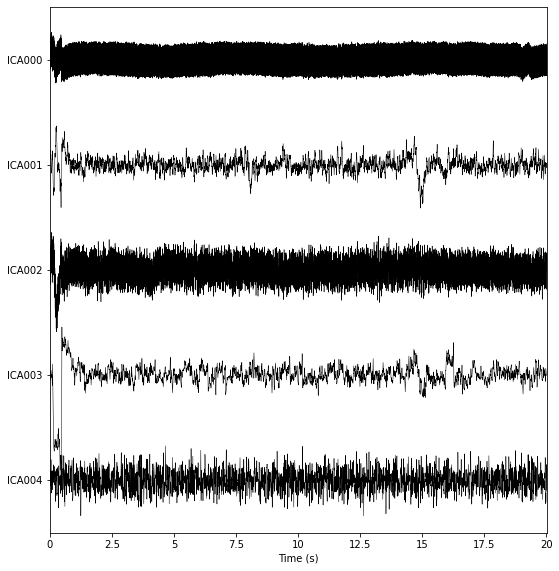

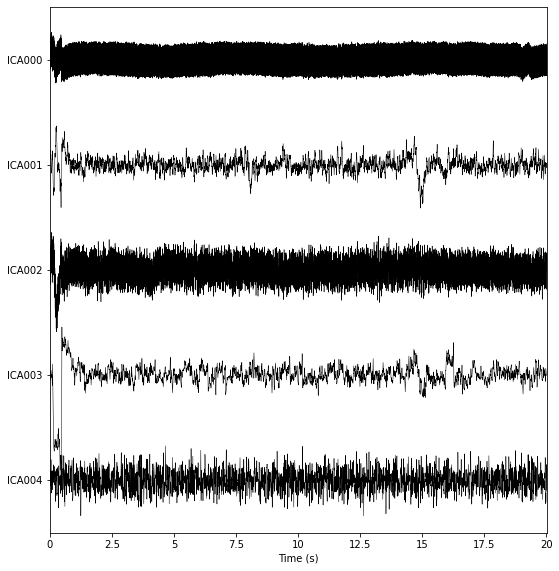

In [ ]:
#ICA
from mne.preprocessing import ICA

raw_ica = raw.copy()
ica=ICA(n_components=5,max_iter='auto')
#n_components < n_channels
ica.fit(raw_ica)
ica
ica.plot_sources(raw_ica, show_scrollbars=False)

In [ ]:
ica.apply(raw_ica)

Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 0 ICA components
    Projecting back using 8 PCA components


<RawArray | 8 x 78840 (315.4 s), ~4.8 MB, data loaded>

Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 1 ICA component
    Projecting back using 5 PCA components


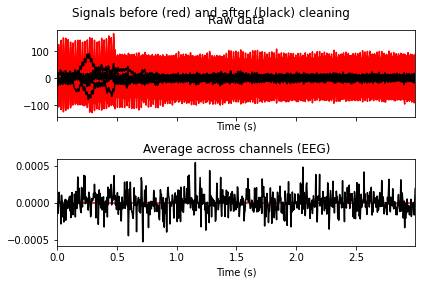

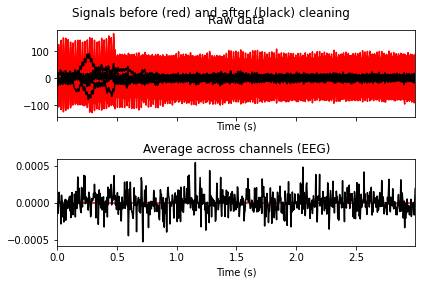

In [ ]:
ica.plot_overlay(raw, exclude=[0], picks='eeg')

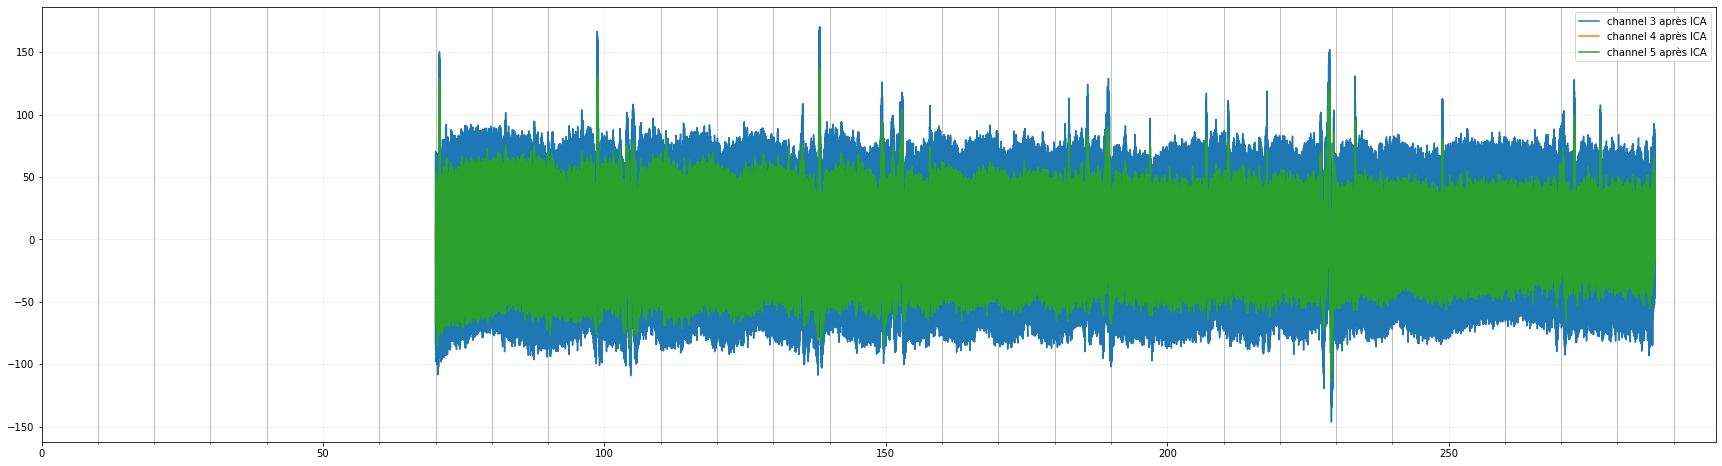

In [ ]:
# Plot 
eeg_array_ica=raw_ica.get_data()
channel1_ica,channel2_ica,channel3_ica,channel4_ica,channel5_ica=eeg_array_ica[0],eeg_array_ica[1],eeg_array_ica[2],eeg_array_ica[3],eeg_array_ica[4]

fig=plt.figure(figsize=(30,8))
ax = fig.add_subplot(1, 1, 1)
plt.plot(time[70*250:],channel3_ica[70*250:],label='channel 3 après ICA')
plt.plot(time[70*250:],channel4_ica[70*250:],label='channel 4 après ICA')
plt.plot(time[70*250:],channel5_ica[70*250:],label='channel 5 après ICA')
#plt.plot(time[70*250:],channel6_ica[70*250:],label='channel 6 après ICA')

grid_x_ticks = np.arange(0, 300, 10)
ax.set_xticks(grid_x_ticks , minor=True)
ax.grid(which='both')
ax.grid(which='major', alpha=0.2, linestyle='-')
plt.legend()
plt.show()

# Potentiels Evoqués Visuels Stationnaires ou SSVEP

In [ ]:
from scipy.stats import ttest_rel
from mne.time_frequency import psd_welch

In [ ]:
#benchmark des événements en secondes
n_segments=3
repos=[[0,47],[92,137],[187,232]]
#le sujet regarde le bouton gauche aux instants...
gauche=[17,107,202]
#le sujet regarde le bouton droite aux instants...
droite=[62,152,247]

[0.7262246279644631, 0.39905798753414035, 1.2032076089182353, 0.5545506082065444, 0.9806299108832455, 0.644825470332827]
[0.7541201535683958, 0.8541439688935609, 0.8853159354958342, 1.5294318445698114, 1.0723494550739041, 1.1672767087273235]


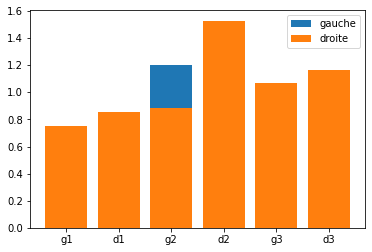

In [ ]:
psd_repos,psd_gauche,psd_droite=[],[],[]

#paramètres à faire varier (largeur de la bande de fréquence pour le calcul de psd, période sur laquelle la psd est calculée (delay))
delay=3
largeur = 0.6
f_gauche=14
f_droite=8

for k in range(0,n_segments):
  #fréquences
  fmd=f_droite-largeur
  fMd=f_droite+largeur
  fmg=f_gauche-largeur
  fMg=f_gauche+largeur


  #gauche
  tmg=(gauche[k])
  tMg=(tmg+delay)
  psdsg, freqsg = mne.time_frequency.psd_welch(raw_ica,
    n_fft=int(f_e * (tMg - tmg)),
    n_overlap=0, n_per_seg=None,
    tmin=tmg, tmax=tMg,
    fmin=fmg, fmax=fMg,
    window='boxcar',
    verbose=False)
  psdsd, freqsd = mne.time_frequency.psd_welch(raw_ica,
    n_fft=int(f_e * (tMg - tmg)),
    n_overlap=0, n_per_seg=None,
    tmin=tmg, tmax=tMg,
    fmin=fmd, fmax=fMd,
    window='boxcar',
    verbose=False)
  psd_gauche.append(psdsg)
  psd_droite.append(psdsd)

  #droite
  tmd=droite[k]
  tMd=tmd+delay
  psdsd, freqsd = mne.time_frequency.psd_welch(raw_ica,
    n_fft=int(f_e * (tMd - tmd)),
    n_overlap=0, n_per_seg=None,
    tmin=tmd, tmax=tMd,
    fmin=fmd, fmax=fMd,
    window='boxcar',
    verbose=False)
  psdsg, freqsg = mne.time_frequency.psd_welch(raw_ica,
    n_fft=int(f_e * (tMd - tmd)),
    n_overlap=0, n_per_seg=None,
    tmin=tmd, tmax=tMd,
    fmin=fmg, fmax=fMg,
    window='boxcar',
    verbose=False)
  psd_droite.append(psdsd)
  psd_gauche.append(psdsg)

#calcul des psd moyennes sur chacun des segments
psd_droite_moy,psd_gauche_moy=[],[]
for k in range(0,len(psd_droite)):
  psd_droite_moy.append(psd_droite[k].mean())
  psd_gauche_moy.append(psd_gauche[k].mean())
print(psd_gauche_moy)
print(psd_droite_moy)

bench=['g1','d1','g2','d2','g3','d3']
plt.bar(bench,psd_gauche_moy,label='gauche')
plt.bar(bench,psd_droite_moy,label='droite')
plt.legend()
plt.show()

In [ ]:
tmin = 1.
tmax = 20.
fmin = 11.5
fmax = 12.5
sfreq = 250

psds2, freqs2 = mne.time_frequency.psd_welch(raw_ica,
    n_fft=int(sfreq * (tmax - tmin)),
    n_overlap=0, n_per_seg=None,
    tmin=tmin, tmax=tmax,
    fmin=fmin, fmax=fmax,
    window='boxcar',
    verbose=False)

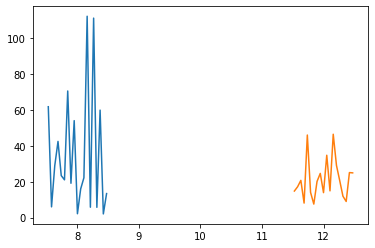

In [ ]:
plt.plot(freqs,psds[1])
plt.plot(freqs2,psds2[1])
plt.show()

Extract SNR values at the stimulation frequency

In [ ]:
stim_g,stim_d=8,12
# find index of frequency bin closest to stimulation frequency
i_bin_12hz = np.argmin(abs(freqs - stim_d))
# could be updated to support multiple frequencies


i_bin_24hz = np.argmin(abs(freqs - 24))
i_bin_36hz = np.argmin(abs(freqs - 36))
i_bin_15hz = np.argmin(abs(freqs - 15))
i_bin_30hz = np.argmin(abs(freqs - 30))
i_bin_45hz = np.argmin(abs(freqs - 45))